# Generalized Linear & Linear Mixed Models

`glm()` and `glmer()` are extensions of `lm()` and `lmer()` models that support non-gaussian outcome variables and support the same methods and attributes. They can be used to estimate modes like logistic regression for binary data and poisson regression for count data.

GLMMs share the same list of methods and attributes available to [LMMs](03_lmms.ipynb).

While these models are relatively simple to use in practice, *interpreting* what parameter estimates mean can be quite tricky based on how complex the model is and what type of `family` and `link` functions you use, with the defaults [listed here](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/family). We highly recommend making using of the `model.emmeans()` and `model.empredict()` methods to instead generate marginal estimates to test specific hypotheses of interest. This tutorial will cover some of these approaches.


In [1]:
from pymer4.models import glm, glmer
import polars as pl, polars.selectors as cs
from polars import col
import seaborn as sns
from pymer4 import load_dataset

## Logistic regression

The titantic dataset contains observations of passenger survival rates that we can stratify by other predictors such as passenger $sex$

We can see that on average only about 19% of male passengers survived

In [2]:
titanic = load_dataset('titanic')
titanic.group_by('sex').agg(col('survived').mean())

sex,survived
str,f64
"""male""",0.188908
"""female""",0.742038


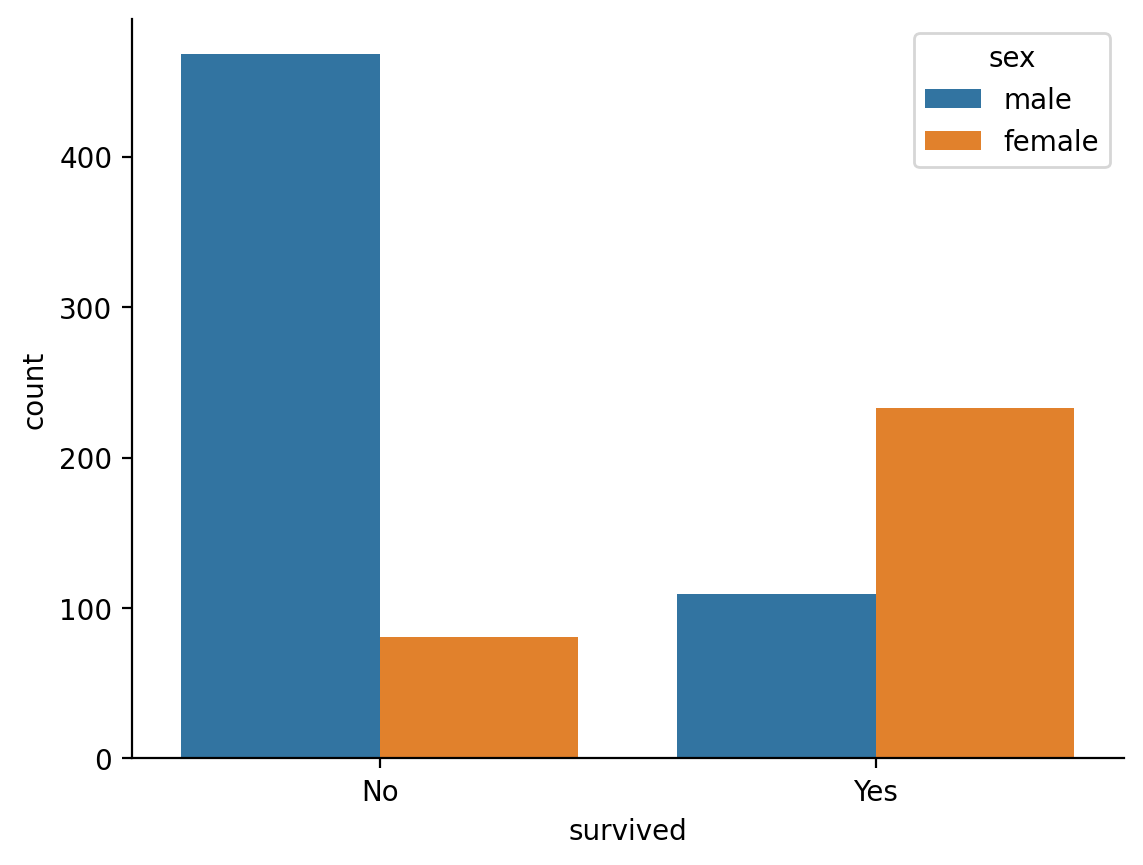

In [3]:
ax = sns.countplot(data=titanic, x='survived', hue='sex')
ax.set_xticks([0,1],['No', 'Yes'])
sns.despine();

We can model whether the probability of survival is different between sexes with a logistic regression which uses a binomial link-function by default.

This means that our parameter estimates are on the *logit* or *log-odds* scale by default which can be hard be a bit interpret. 

$$
\begin{align*}
p &= probability \\
odds &= \frac{p}{1-p} \\
log\ odds &= logit(p) = ln(\frac{p}{1-p})
\end{align*}
$$

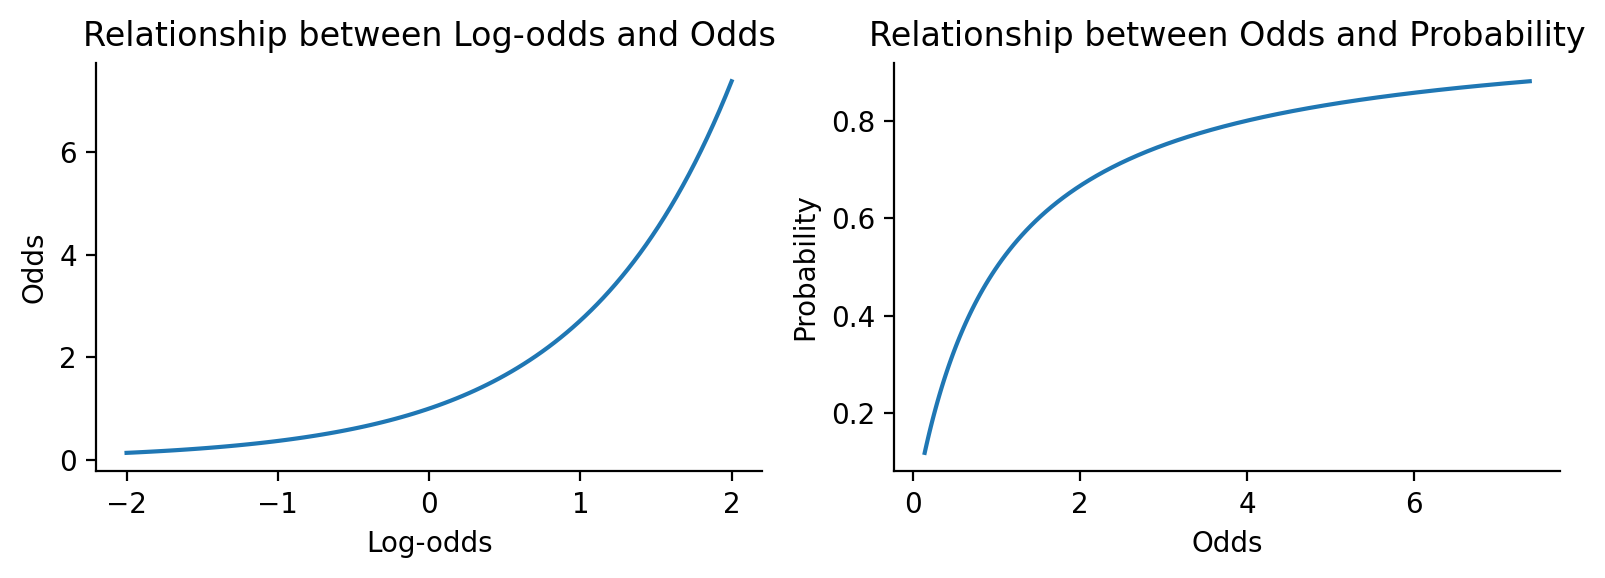

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# Create a range of log-odds values
log_odds = np.linspace(-2, 2, 100)

# Convert to odds and probability
odds = np.exp(log_odds)
prob = odds / (1 + odds)

# Create the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# Plot log-odds vs odds
ax1.plot(log_odds, odds)
ax1.set_xlabel('Log-odds')
ax1.set_ylabel('Odds')
ax1.set_title('Relationship between Log-odds and Odds')

# Plot odds vs probability
ax2.plot(odds, prob)
ax2.set_xlabel('Odds')
ax2.set_ylabel('Probability')
ax2.set_title('Relationship between Odds and Probability')

plt.tight_layout()
sns.despine();


In [5]:
log_regress = glm('survived ~ sex', data=titanic, family='binomial')
log_regress.set_factors('sex')
log_regress.fit()
log_regress.params

term,estimate
str,f64
"""(Intercept)""",1.056589
"""sexmale""",-2.51371


It can be helpful to make these more interpretable by *expontentiating* the parameters to be on the odds-scale

In [6]:
log_regress.fit(exponentiate=True)
log_regress.params

term,estimate
str,f64
"""(Intercept)""",2.876543
"""sexmale""",0.080967


This shows that Males have .08 odds relative to females of surviving 

We can see a full summary view with odds-converted estimates as well

In [7]:
log_regress.summary()

GT(_tbl_data=shape: (2, 9)
┌─────────────┬──────────┬───────────┬──────────┬───┬────────────┬─────┬─────────┬───────┐
│ term        ┆ estimate ┆ std_error ┆ conf_low ┆ … ┆ z_stat     ┆ df  ┆ p_value ┆ stars │
│ ---         ┆ ---      ┆ ---       ┆ ---      ┆   ┆ ---        ┆ --- ┆ ---     ┆ ---   │
│ str         ┆ f64      ┆ f64       ┆ f64      ┆   ┆ f64        ┆ f64 ┆ str     ┆ str   │
╞═════════════╪══════════╪═══════════╪══════════╪═══╪════════════╪═════╪═════════╪═══════╡
│ (Intercept) ┆ 2.876543 ┆ 0.371035  ┆ 2.233971 ┆ … ┆ 8.191477   ┆ inf ┆ <.001   ┆ ***   │
│ sexmale     ┆ 0.080967 ┆ 0.013536  ┆ 0.058346 ┆ … ┆ -15.036107 ┆ inf ┆ <.001   ┆ ***   │
└─────────────┴──────────┴───────────┴──────────┴───┴────────────┴─────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x31bb6e030>, _boxhead=Boxhead([ColInfo(var='term', type=<ColInfoTypeEnum.stub: 2>, column_label='term', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='z_stat', type=<ColInfoTypeEnum.default: 1>, column_label='Z-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='df', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x31f85d580>, _spanners=Spanners([]), _heading=Heading(title='Formula: glm(survived~sex)', subtitle=Md(text='Family: *binomial (link: *default*)*  \n            Number of observations: *891*  \n            Confidence intervals: *parametric*  \n            ---------------------  \n            Log-likelihood: *-458*  \n            AIC: *921* | BIC: *931*  \n            Residual deviance: *917* | DF: *889*  \n            Null deviance: *1186* | DF: *890*  \n        '), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[StyleInfo(locname=LocStub(rows=None), grpname=None, colname=None, rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocStub(rows=None), grpname=None, colname=None, rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)])], _locale=<great_tables._gt_data.Locale object at 0x31c970f80>, _formats=[<great_tables._gt_data.FormatInfo object at 0x31c9d9cd0>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', t

### Marginal estimates

In logistic regression, it's often of interest to pose questions on the *probability* scale rather than the log-odds or odds scale. For example, what are the respective probabilities of survival for males vs females?

For these kinds of analyses and especially as models include more terms, it's often a lot easier to use *marginal estimates* and comparisons rather than trying to interpet `.params` or `.summary()` directly

We can do this with the `.emmeans()` and `.empredict()` functions which uses `type='response'` by default to give us probabilities

In [8]:
# Probability of survival by sex
log_regress.emmeans('sex')

sex,prob,SE,df,asymp_LCL,asymp_UCL
cat,f64,f64,f64,f64,f64
"""female""",0.742038,0.02469,inf,0.683113,0.793322
"""male""",0.188908,0.016296,inf,0.155122,0.228066


Now we can pose questions in terms of *contrasts* between these estimates.  

This general approach can help make a variety of GLMs much easier to work with. For illustration, contrasting male > female marginal-estimates on the probability-scale, is equivalent to the ratio between the probabilities on the odds-scale, which is what $sexmale$ represents using `.summary(show_odds=True)`


In [9]:
log_regress.emmeans('sex', contrasts={'female_minus_male': [-1, 1]})

contrast,odds_ratio,SE,df,asymp_LCL,asymp_UCL,null,z_ratio,p_value
cat,f64,f64,f64,f64,f64,f64,f64,f64
"""female_minus_male""",0.080967,0.013536,inf,0.058346,0.11236,1.0,-15.036107,4.2587e-51


If we switch the default `type` to `'link'` we'll be comparing estimates on the log-odds scale, which is the same as the untransformed parameter estimate for $sexmale$

In [10]:
# Log-odds scale
log_regress.emmeans('sex', type='link')

sex,emmean,SE,df,asymp_LCL,asymp_UCL
cat,f64,f64,f64,f64,f64
"""female""",1.056589,0.128986,inf,0.768114,1.345064
"""male""",-1.45712,0.106353,inf,-1.694977,-1.219263


In [11]:
# Contrast is same as untransformed parameter estimate
log_regress.emmeans('sex', contrasts={'female_minus_male': [-1, 1]}, type='link')

contrast,estimate,SE,df,asymp_LCL,asymp_UCL,z_ratio,p_value
str,f64,f64,f64,f64,f64,f64,f64
"""female_minus_male""",-2.51371,0.167178,inf,-2.841373,-2.186046,-15.036107,4.2587e-51


### Link functions

For all `glm` models we can switch to another supported link function. A common one for logistic regression is the `'probit'` link function which models probability using the inverse of standard normal cumulative distribution function:

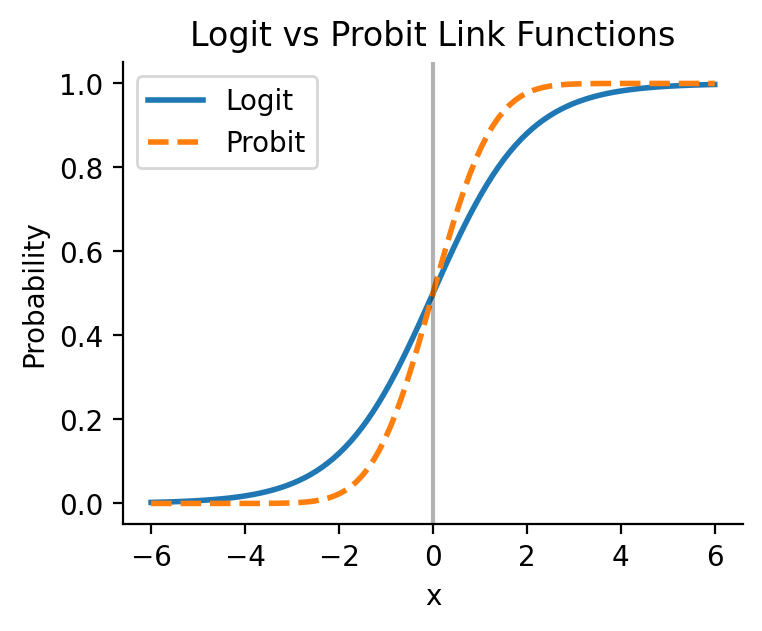

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Generate x values from -6 to 6
x = np.linspace(-6, 6, 100)

# Calculate logistic function: 1 / (1 + exp(-x))
logistic = 1 / (1 + np.exp(-x))

# Calculate probit function: standard normal CDF
probit = norm.cdf(x)

# Create plot
plt.figure(figsize=(4,3))
plt.plot(x, logistic, label='Logit', linewidth=2)
plt.plot(x, probit, label='Probit', linewidth=2, linestyle='--')
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Logit vs Probit Link Functions')
plt.legend()
plt.axvline(x=0, color='k', alpha=0.3)
sns.despine();


Parameter estimates from a probit model are typically interpreted as the change in *z-score* of the probability of the outcome under a standard normali distribution.

In [14]:
probit_regress = glm('survived ~ sex', data=titanic, family='binomial', link='probit')
probit_regress.set_factors('sex')
probit_regress.fit()
probit_regress.params

term,estimate
str,f64
"""(Intercept)""",0.649642
"""sexmale""",-1.531569


This this scale can be just as hard to interpret as logits/log-odds. And with non-`'logit'` link functions, there isn't a consistent way to transform parameter estimates to another scale.

Not to worry, we can use the marginal estimation approach again via `.emmeans()` to generate predictions and compare probabilities between sexes

In [15]:
probit_regress.emmeans('sex')

sex,prob,SE,df,asymp_LCL,asymp_UCL
cat,f64,f64,f64,f64,f64
"""female""",0.742038,0.02469,inf,0.683927,0.794056
"""male""",0.188908,0.016296,inf,0.154647,0.227487


In a more complicated model this can come in very handy for understanding and exploring interactions between predictors:

In [17]:
probit_regress = glm('survived ~ sex * age', data=titanic, family='binomial', link='probit')
probit_regress.set_factors('sex')

# Center age
probit_regress.set_transforms({'age': 'center'})
probit_regress.fit()

# Make predictions for each sex across a range of ages
age_predictions = probit_regress.empredict({
    'sex': ['male', 'female'],
    'age': np.arange(1, 101,1)
    })

# Plot them

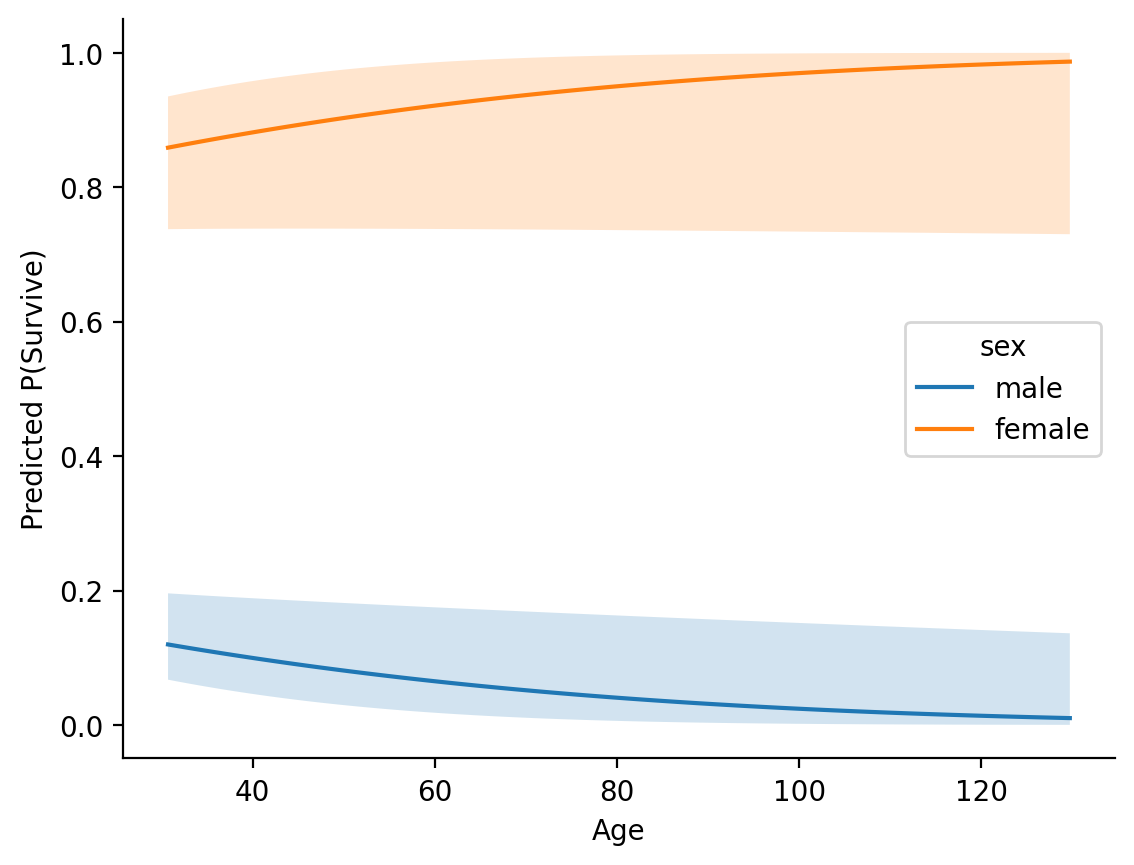

In [18]:
males = age_predictions.filter(col('sex') == 'male')
females = age_predictions.filter(col('sex') == 'female')

ax =sns.lineplot(data=age_predictions, x='age', y='prob', hue='sex')
ax.fill_between(males['age'], males['asymp_LCL'], males['asymp_UCL'], alpha=0.2)
ax.fill_between(females['age'], females['asymp_LCL'], females['asymp_UCL'],alpha=0.2);
ax.set(xlabel='Age', ylabel='Predicted P(Survive)')
sns.despine();

## Multi-level Logistic Regression

We can extend our model to account for the variability across passenger classes by swapping out `glm()` for `glmer()` and specifying a random-effects term in this case passenger class

In [ ]:
from pymer4.models import glmer

log_lmm = glmer('survived ~ sex + (1 | pclass)', data=titanic, family='binomial')
log_lmm.set_factors('pclass')

# Convert estimates to odds
log_lmm.fit(exponentiate=True)
log_lmm.summary()

GT(_tbl_data=shape: (5, 10)
┌────────────────┬─────────────┬──────────┬──────────┬───┬────────────┬──────┬──────────┬───────┐
│ rfx            ┆ param       ┆ estimate ┆ conf_low ┆ … ┆ z_stat     ┆ df   ┆ p_value  ┆ stars │
│ ---            ┆ ---         ┆ ---      ┆ ---      ┆   ┆ ---        ┆ ---  ┆ ---      ┆ ---   │
│ str            ┆ str         ┆ f64      ┆ f64      ┆   ┆ f64        ┆ f64  ┆ str      ┆ str   │
╞════════════════╪═════════════╪══════════╪══════════╪═══╪════════════╪══════╪══════════╪═══════╡
│ pclass-sd      ┆ (Intercept) ┆ 0.769266 ┆ null     ┆ … ┆ null       ┆ null ┆ null     ┆ null  │
│ null           ┆ null        ┆ null     ┆ null     ┆ … ┆ null       ┆ null ┆ null     ┆ null  │
│ Fixed Effects: ┆ null        ┆ null     ┆ null     ┆ … ┆ null       ┆ null ┆ null     ┆ null  │
│ null           ┆ (Intercept) ┆ 3.942049 ┆ 1.576347 ┆ … ┆ 2.933134   ┆ inf  ┆ 0.003356 ┆ **    │
│ null           ┆ sexmale     ┆ 0.071631 ┆ 0.05     ┆ … ┆ -14.371837 ┆ inf  ┆ <.001    ┆ ***   │
└────────────────┴─────────────┴──────────┴──────────┴───┴────────────┴──────┴──────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x311d74bc0>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='z_stat', type=<ColInfoTypeEnum.default: 1>, column_label='Z-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='df', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x311d77f80>, _spanners=Spanners([]), _heading=Heading(title='Formula: glmer(survived~sex+(1|pclass))', subtitle=Md(text='Family: *binomial (link: *default*)*  \n            Number of observations: *891*  \n            Confidence intervals: *parametric*  \n            ---------------------  \n            Log-likelihood: *-419*  \n            AIC: *845* | BIC: *860*  \n            Residual error: *1.0*  \n        '), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=['param'], rows=None), grpname=None, colname='param', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None), grpname=None, colname='param', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None), grpname=None, colname='param', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align=None, v_align=None, style='italic', weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['param'], rows=None), grpname=None, colname='param', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=

This accounts for the variability across each class, nested inside which are multiple observations for each sex. We can explore the odds estimates for each class which captures the variability in the odds of survival across each cluster of observations:

In [9]:
log_lmm.ranef

level,(Intercept)
str,f64
"""1""",2.413829
"""2""",1.082862
"""3""",0.383755


In [10]:
log_lmm.fixef

level,(Intercept),sexmale
str,f64,f64
"""1""",9.515432,0.071631
"""2""",4.268696,0.071631
"""3""",1.512781,0.071631


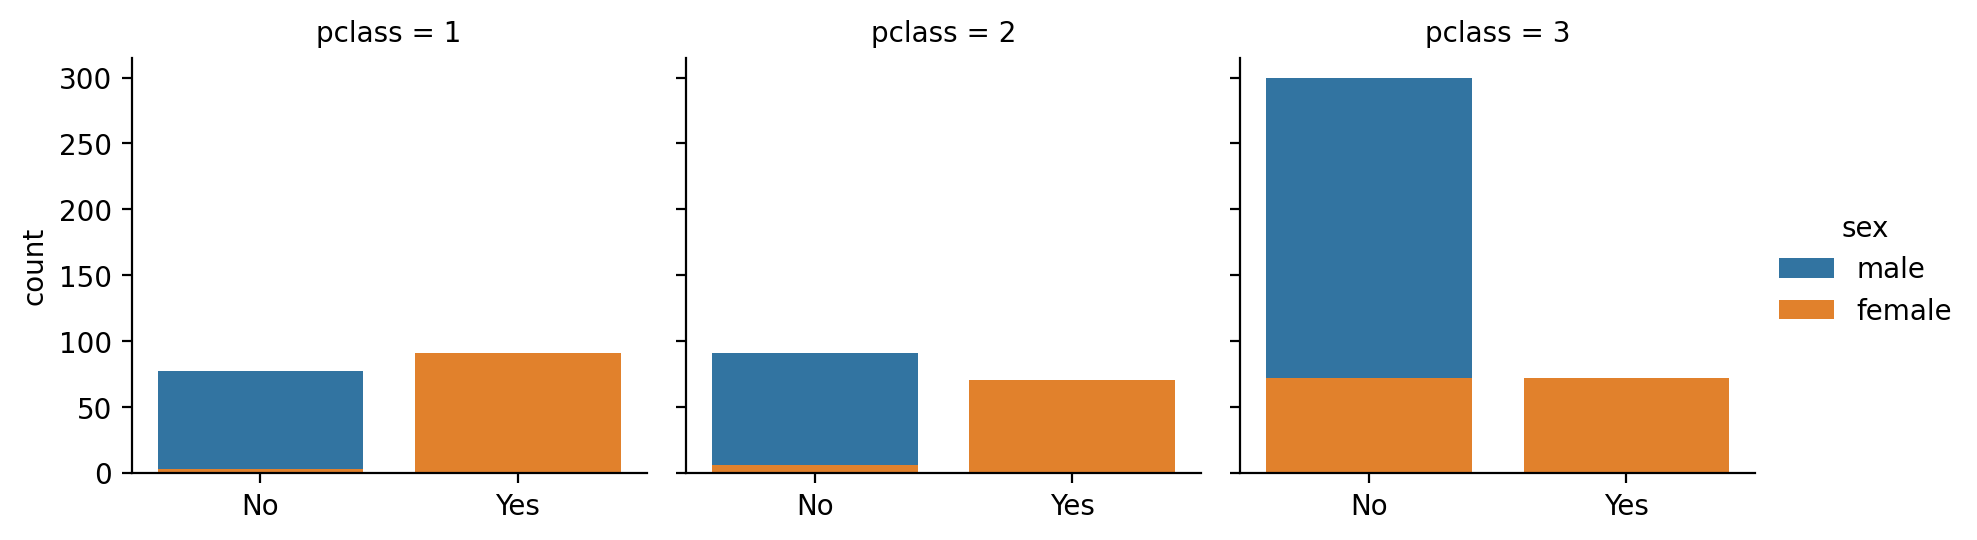

In [11]:
grid = sns.FacetGrid(titanic, col='pclass', hue='sex',)
grid.map(sns.countplot, 'survived', order=[0,1])
grid.add_legend()
grid.set_xlabels("")
grid.set_xticklabels(['No', 'Yes'])
sns.despine();

## Summary

GLMs and GLMMs support a variety of additional families and link functions for working with different types of data (e.g. `family = 'poisson'` for count data). You can find a full [list here](https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/family)
